In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [3]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


**A short description of the features**

* datetime - hourly date + timestamp
* season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather -
  
  1: Clear, Few clouds, Partly cloudy, Partly cloudy
  
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


# Exploratory Data Analysis (EDA)

**Plot in categorical variable**

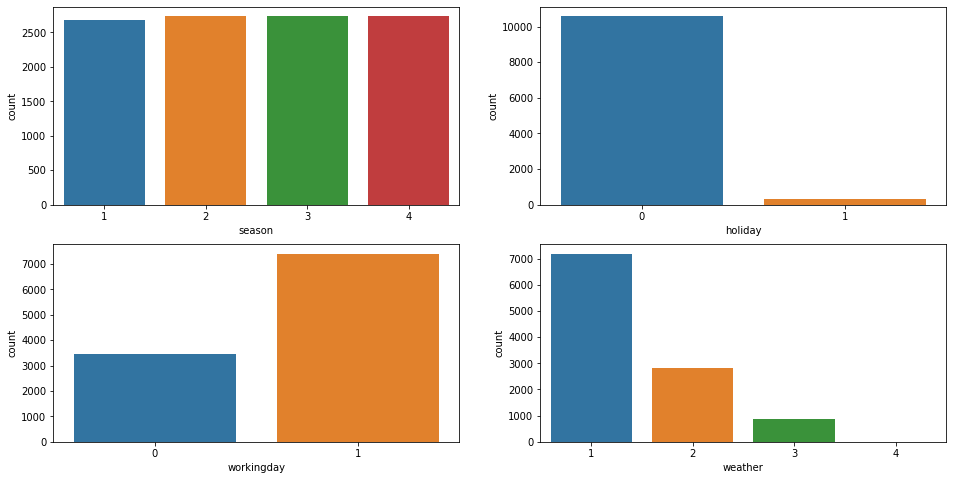

In [6]:
# countplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16,8)

sns.countplot(train['season'], ax=axes[0][0])
sns.countplot(train['holiday'], ax=axes[0][1])
sns.countplot(train['workingday'], ax=axes[1][0])
sns.countplot(train['weather'], ax=axes[1][1])

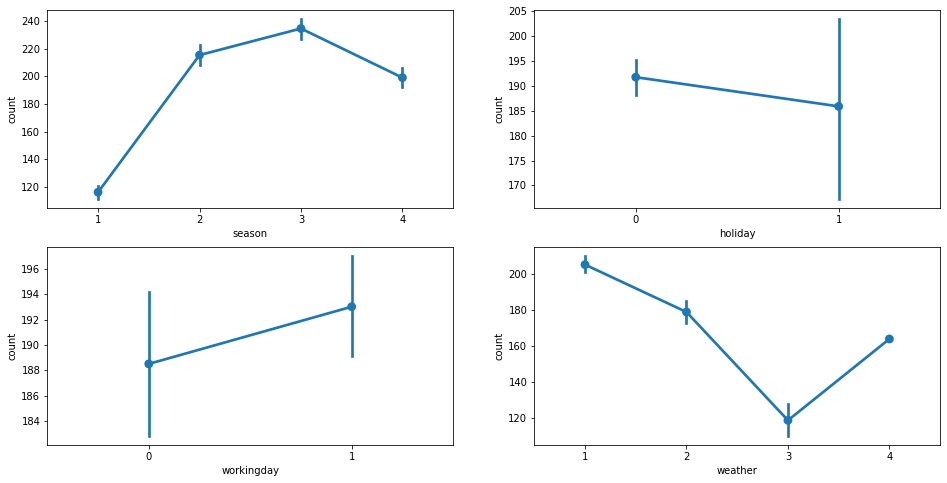

In [7]:
# pointplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16,8)

sns.pointplot(data=train, x='season', y='count', ax=axes[0][0])
sns.pointplot(data=train, x='holiday',y='count', ax=axes[0][1])
sns.pointplot(data=train, x='workingday',y='count', ax=axes[1][0])
sns.pointplot(data=train, x='weather',y='count', ax=axes[1][1])

In [8]:
# count in the worst weather 
train[train['weather']==4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164


**Insight:**
*   season: There are high rental demand in summer and fall.
*   holiday/working: Rental count in workingday is much more than that in holiday.
*   weather: Rental count is large in good weather.


---



**Plot continuous variable**

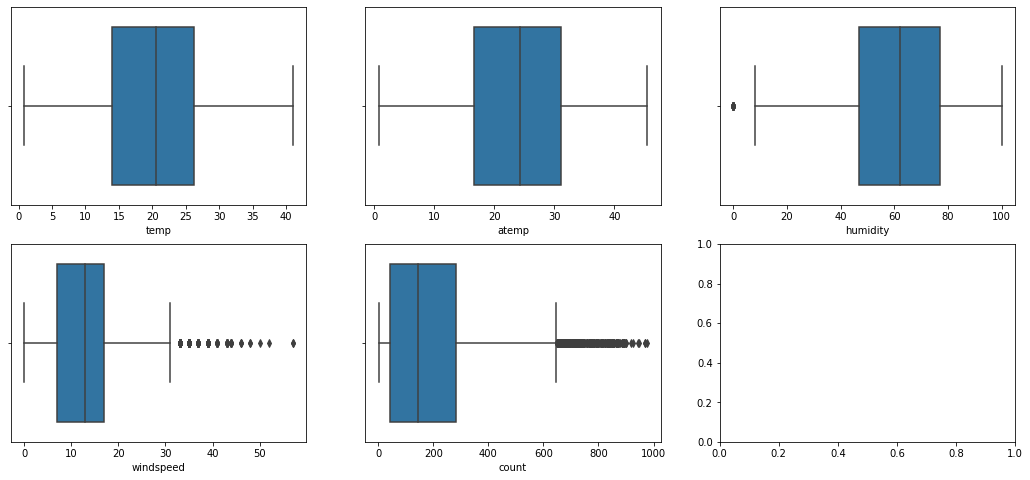

In [9]:
# boxplot in continuous variable
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(18,8)

sns.boxplot(train['temp'], ax=axes[0][0])
sns.boxplot(train['atemp'], ax=axes[0][1])
sns.boxplot(train['humidity'], ax=axes[0][2])
sns.boxplot(train['windspeed'], ax=axes[1][0])
sns.boxplot(train['count'], ax=axes[1][1])

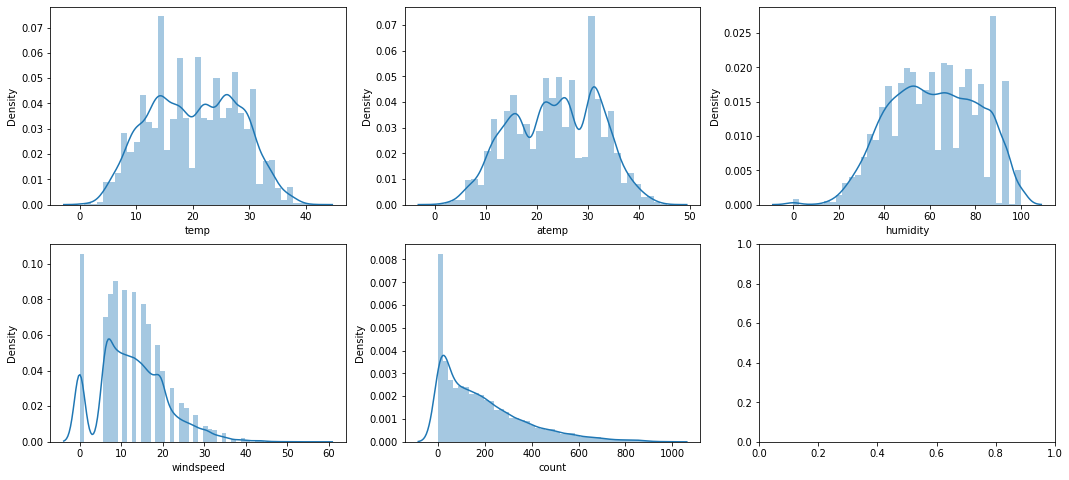

In [10]:
# distplot in continuous variable
fig, axes = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(18,8)

sns.distplot(train['temp'],ax=axes[0][0])
sns.distplot(train['atemp'],ax=axes[0][1])
sns.distplot(train['humidity'],ax=axes[0][2])
sns.distplot(train['windspeed'],ax=axes[1][0])
sns.distplot(train['count'],ax=axes[1][1])

**Insight：**

*   count : There are lots of outlier in count.
*   windspeed : According to the common sense that windspeed is continuous variable, but actually no. Maybe someone filled the missing values up with 0. I will use randomfores model to refill the missing values up with reasonable value.

---





**Correlation matrix**

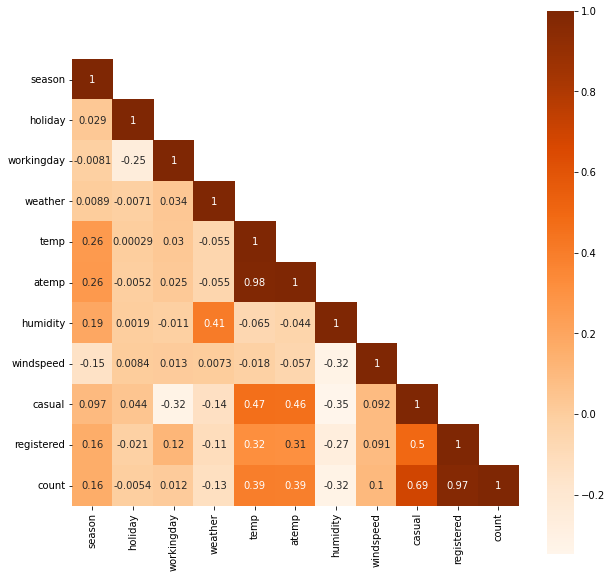

In [11]:
corr = train.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data=corr,
            mask=mask,
            cmap='Oranges',
            square=True,
            annot=True,
            cbar=True)

# Feature Engineering 

**Outliers Detection**

In [12]:
# delect the outliers
print('before delect train outlier: ', train.shape)
train = train[np.abs(train['count']-train['count'].mean()) <= 3*train['count'].std()]
print('before delect train outlier: ', train.shape)

before delect train outlier:  (10886, 12)
before delect train outlier:  (10739, 12)


**Feature Transformation in datetime**

In [13]:
weekday={'Sunday':0,
        'Monday':1,
        'Tuesday':2,
        'Wednesday':3,
        'Thursday':4,
        'Friday':5,
        'Saturday':6}

In [14]:
# train dataset
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d %H:%M:%S')
train['year']=train['datetime'].dt.year
train['year']=train['year'].map({2011:0, 2012:1})
train['month']=train['datetime'].dt.month
train['weekday']=pd.DatetimeIndex(train['datetime']).day_name()
train['weekday']=train['weekday'].map(weekday)
train['hour']=train['datetime'].dt.hour

In [15]:
# test dataset
test['datetime'] = pd.to_datetime(test['datetime'], format='%Y-%m-%d %H:%M:%S')
test['year']=test['datetime'].dt.year
test['year']=test['year'].map({2011:0, 2012:1})
test['month']=test['datetime'].dt.month
test['weekday']=pd.DatetimeIndex(test['datetime']).day_name()
test['weekday']=test['weekday'].map(weekday)
test['hour']=test['datetime'].dt.hour

In [16]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,6,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,0,1,6,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,0,1,6,2


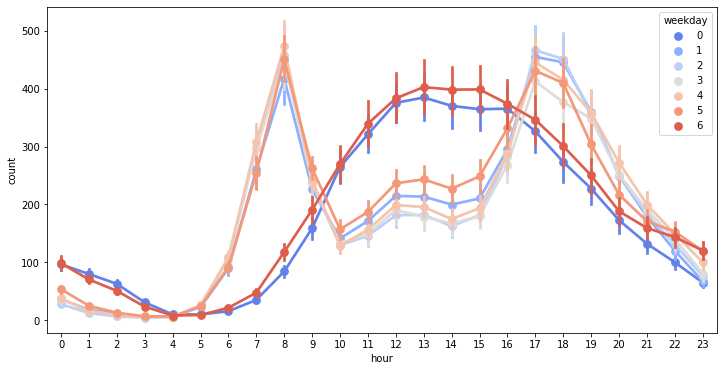

In [17]:
fig=plt.gcf()
fig.set_size_inches(12,6)
sns.pointplot(x = 'hour', y = 'count', data = train, 
              estimator=np.average, hue = 'weekday', palette='coolwarm')

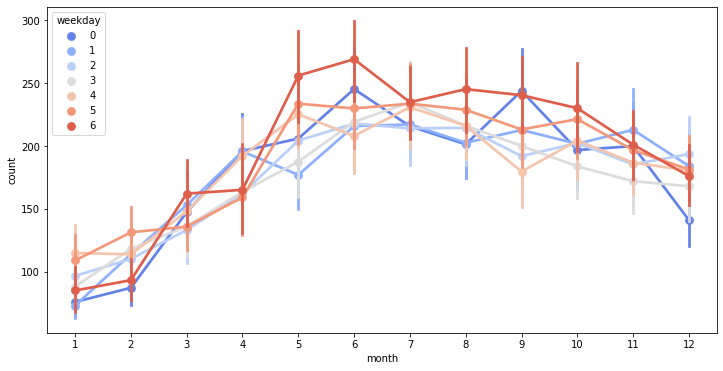

In [18]:
fig=plt.gcf()
fig.set_size_inches(12,6)
sns.pointplot(x = 'month', y = 'count', data = train, 
              estimator=np.average, hue = 'weekday', palette='coolwarm')

**Feature Transformation in categorical variable**

Try two methon:
* Leave-One-Out Encoding
* Astype to category

The method 'Leave-One-Out Encoding' isn't more effective than the method 'Astype to category', so use the second way in feature transformation.


In [19]:
# Leave-One-Out Encoding

# pip install category_encoders
# import category_encoders as ce

# def LOO_Encoding(feature):
#   global train, test
#   for i in feature:
#     encoder = ce.LeaveOneOutEncoder(cols=[i], sigma=0.05)
#     train[i] = encoder.fit_transform(train[i], train['count'])
#     test[i] = encoder.transform(test[i])
#   return print('Finishing LOO_Encoding in categorical variable:\n', feature)

# feature_LOO = ['season','holiday','workingday','weather',
#                'year','month','weekday','hour']
# LOO_Encoding(feature_LOO)

In [20]:
# Astype to category
category_feature = ['season','holiday','workingday','weather',
                    'year','month','weekday','hour']

for i in category_feature:
  train[i] = train[i].astype('category')
  test[i] = test[i].astype('category')

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10739 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10739 non-null  datetime64[ns]
 1   season      10739 non-null  category      
 2   holiday     10739 non-null  category      
 3   workingday  10739 non-null  category      
 4   weather     10739 non-null  category      
 5   temp        10739 non-null  float64       
 6   atemp       10739 non-null  float64       
 7   humidity    10739 non-null  int64         
 8   windspeed   10739 non-null  float64       
 9   casual      10739 non-null  int64         
 10  registered  10739 non-null  int64         
 11  count       10739 non-null  int64         
 12  year        10739 non-null  category      
 13  month       10739 non-null  category      
 14  weekday     10739 non-null  category      
 15  hour        10739 non-null  category      
dtypes: category(8), dateti

**Missing Value Imputation in windspeed**

In [22]:
# Combine train & test
data = train.append(test, ignore_index=True)

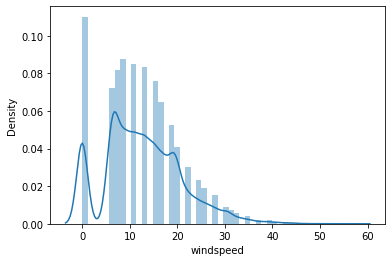

In [23]:
# plot windspeed
sns.distplot(data['windspeed'])

In [24]:
windFeatures = ['season', 'weather', 'temp', 'atemp', 'humidity', 'year', 'month', 'weekday', 'hour']

windspeedIs0 = data[data['windspeed']==0]
windspeedIsNot0  = data[data['windspeed']!=0]

X = windspeedIsNot0[windFeatures]
y = windspeedIsNot0['windspeed']

In [25]:
# use train_test data to evaluate model effectiveness
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)
rfModel.fit(x_train1, y_train1)
y_pred1 = rfModel.predict(x_test1)

In [26]:
# evaluate randomforest model effectiveness
from sklearn.metrics import mean_squared_error, mean_squared_log_error
wind_RMSE = np.sqrt(mean_squared_error(y_test1, y_pred1))
wind_RMSLE = np.sqrt(mean_squared_log_error(y_test1, y_pred1))

print('wind_RMSE: ', wind_RMSE)
print('wind_RMSLE: ', wind_RMSLE)

wind_RMSE:  4.838987451145299
wind_RMSLE:  0.32131550162636346


In [27]:
# fill up wind_zero_values in data
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)
rfModel.fit(X,y)
wind0Values = rfModel.predict(windspeedIs0[windFeatures])
windspeedIs0.loc[:,'windspeed'] = wind0Values

data = pd.concat((windspeedIs0, windspeedIsNot0), axis=0)

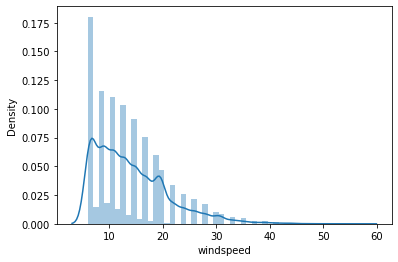

In [28]:
# plot windspeed after filling up 0 value
sns.distplot(data['windspeed'])

**Split train and test dataset**

In [29]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by='datetime')
dataTest = data[~pd.notnull(data['count'])].sort_values(by='datetime')

dataTrain_Y = dataTrain['count']
datetimeCol = dataTest['datetime']

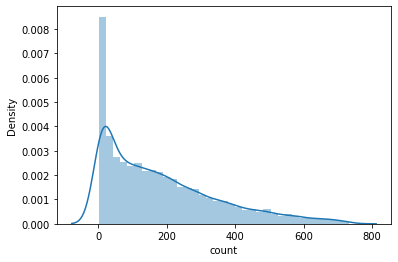

In [30]:
# dataTrain_Y
sns.distplot(dataTrain_Y)

In [31]:
# log Y
dataTrain_Y_log = np.log(dataTrain_Y)

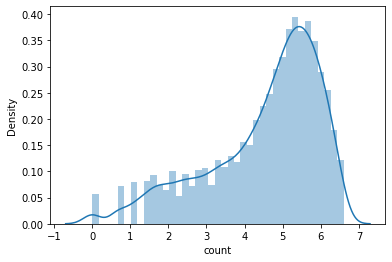

In [32]:
# dataTrain_Y_log
sns.distplot(dataTrain_Y_log)

**Delete unnecessary columns**

In [33]:
dropFeatures = ['datetime','casual','registered','count']
dataTrain = dataTrain.drop(dropFeatures, axis=1)
dataTest = dataTest.drop(dropFeatures, axis=1)

In [34]:
dataTrain.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,weekday,hour
0,1,0,0,1,9.84,14.395,81,6.423799,0,1,6,0
1,1,0,0,1,9.02,13.635,80,6.309859,0,1,6,1
2,1,0,0,1,9.02,13.635,80,6.340880,0,1,6,2


**Build machine learning models**
* Linear regression
* Polynomial regression
* RandomForest regressor

In [36]:
# evaluate model effectiveness function
def evaluate_model_RMSE(modelName, y_test, y_pred):
  train_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
  train_RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))

  print(modelName, ' train_RMSE : ', train_RMSE)
  print(modelName, ' train_RMSLE : ', train_RMSLE)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(dataTrain.values,
                                                    dataTrain_Y_log.values,
                                                    test_size=0.2, random_state=42, shuffle=True)

In [38]:
# Linear Regression
LR = LinearRegression()
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)

evaluate_model_RMSE('LinearRegression',y_test,y_pred)

LinearRegression  train_RMSE :  1.0440506947300905
LinearRegression  train_RMSLE :  0.2579802369846637


In [39]:
# Polynomial regression
deg = 3
regressor_poly = PolynomialFeatures(degree=deg)
x_train_poly = regressor_poly.fit_transform(x_train)
x_test_poly = regressor_poly.fit_transform(x_test)

LR = LinearRegression()
LR.fit(x_train_poly, y_train)
y_pred_poly = LR.predict(x_test_poly)
y_pred_poly = [max(0,x) for x in y_pred_poly]

evaluate_model_RMSE('LinearRegression Poly',y_test,y_pred_poly)

LinearRegression Poly  train_RMSE :  0.8292460915315091
LinearRegression Poly  train_RMSLE :  0.2191700713328483


In [40]:
# RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)
rfModel.fit(x_train, y_train)
y_pred_rf = rfModel.predict(x_test)

evaluate_model_RMSE('RandomForest', y_test, y_pred_rf)

RandomForest  train_RMSE :  0.32429592773072136
RandomForest  train_RMSLE :  0.10576719794527362


In [43]:
XGB = XGBRegressor(learning_rate = 0.1)
XGB.fit(x_train, y_train)
y_pred_XGB = XGB.predict(x_test)

evaluate_model_RMSE('XGBRegressor', y_test, y_pred_XGB)

[14:36:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor  train_RMSE :  0.3969051860108843
XGBRegressor  train_RMSLE :  0.11844127461454079


**Choose model : RandomForest Regressor**

In [44]:
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)
rfModel.fit(dataTrain, dataTrain_Y_log)
dataTest_Y_log = rfModel.predict(dataTest)

In [45]:
dataTest_Y = [max(0,x) for x in np.exp(dataTest_Y_log)]

In [46]:
result = pd.DataFrame({
    'datetime' : datetimeCol,
    'count' : dataTest_Y
})

In [47]:
result.to_csv('bike_prediction.csv',index=False)